In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np
import pandas as pd
from stochastic_rnn import StochasticLSTM
from stochastic_module import StochasticSingleOutputModule
from train_utils import weight_coefficient, bias_coefficient, filter_parameters, train_model

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import minmax_scale

In [6]:
from classification_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, uncertainty_avg, prediction_avg

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
np.random.seed(1234)
torch.manual_seed(1234)

In [9]:
training_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Training.data", sep=',', dtype=np.float64)
testing_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Testing.data", sep=',', dtype=np.float64)

In [10]:
training_table.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,class
0,39.02,36.49,38.20,38.85,39.38,39.74,37.02,39.53,38.81,38.79,...,36.62,36.92,38.80,38.52,38.07,36.73,39.46,37.50,39.10,0.0
1,1.83,1.71,1.77,1.77,1.68,1.78,1.80,1.70,1.75,1.78,...,1.80,1.79,1.77,1.74,1.74,1.80,1.78,1.75,1.69,1.0
2,68177.69,66138.42,72981.88,74304.33,67549.66,69367.34,69169.41,73268.61,74465.84,72503.37,...,73438.88,71053.35,71112.62,74916.48,72571.58,66348.97,71063.72,67404.27,74920.24,1.0
3,44889.06,39191.86,40728.46,38576.36,45876.06,47034.00,46611.43,37668.32,40980.89,38466.15,...,42625.67,40684.20,46960.73,44546.80,45410.53,47139.44,43095.68,40888.34,39615.19,0.0
4,5.70,5.40,5.28,5.38,5.27,5.61,6.00,5.38,5.34,5.87,...,5.17,5.67,5.60,5.94,5.73,5.22,5.30,5.73,5.91,0.0


In [11]:
dim = 1
seq_length = 100
DROP = 0.5
ls = 1e-2
tau = 1

In [12]:
x_train = minmax_scale(training_table.drop("class", axis=1).values, axis=1)
y_train = torch.tensor(training_table["class"].values)
x_test = minmax_scale(testing_table.drop("class", axis=1).values, axis=1)
y_test = torch.tensor(testing_table["class"].values)

x_train = torch.tensor(np.expand_dims(x_train, axis=-1))
x_test = torch.tensor(np.expand_dims(x_test, axis=-1))

N = len(y_train)

train_dl = torch.utils.data.DataLoader(
        [(x_train[i], y_train[i]) for i in range(len(y_train))],
        batch_size=10,
        shuffle=True
)

In [13]:
class Net(StochasticSingleOutputModule):
    def __init__(self):
        super(Net, self).__init__(sample_size=10)
        self.rnn = StochasticLSTM(1, 10, DROP)
        self.fc = nn.Linear(10, 1)
        #self.fc = nn.Linear(10 * seq_length, 1)

    def forward(self, x: torch.Tensor):
        out, _ = self.rnn(x)
        out = out[-1]
        #out = out.transpose(-2,-3).flatten(-2)
        out = torch.tanh(out)
        out = self.fc(out)
        return out

In [14]:
net = Net().double()
criterion = nn.BCEWithLogitsLoss()

M = filter_parameters(net.named_parameters(), "rnn", "weight")
m = filter_parameters(net.named_parameters(), "rnn", "bias")
other_params = filter_parameters(net.named_parameters(), "fc", "")

parameters = [
    {"params": M, "weight_decay": weight_coefficient(ls, tau, DROP, N)}, # dropout rnn weight
    {"params": m, "weight_decay": bias_coefficient(ls, tau, N)}, # dropout rnn bias
    {"params": other_params} # other parameters
]
optimizer = optim.Adam(parameters, lr=1e-3)

In [15]:
train_model(net, train_dl, criterion, optimizer, 5)

[1, 100.00%] loss: 0.668787
[2, 100.00%] loss: 0.608871
[3, 100.00%] loss: 0.458634
[4, 100.00%] loss: 0.283135
[5, 100.00%] loss: 0.212357
Finish training


In [16]:
net.eval()
with torch.no_grad():
    outputs = net(x_test.transpose(-2, -3))
    outputs = torch.sigmoid(outputs)
    outputs = outputs.flatten(1)
    uncertainties = uncertainty_avg(outputs)
    predictions = prediction_avg(outputs)

In [17]:
roc_auc_score(y_test, predictions)

1.0

In [18]:
A = aleatoric_uncertainty(outputs)
E = epistemic_uncertainty(outputs)

In [19]:
for i in range(10):
    print("Entry %3i: label (%.0f), prediction (%.4f), uncertainty (%.4f), aleatoric (%.6f), epistemic (%.6f)" % (i, y_test[i], predictions[i], uncertainties[i], A[i], E[i]))

Entry   0: label (1), prediction (0.8156), uncertainty (0.1504), aleatoric (0.147565), epistemic (0.002856)
Entry   1: label (0), prediction (0.1123), uncertainty (0.0997), aleatoric (0.099534), epistemic (0.000167)
Entry   2: label (0), prediction (0.1223), uncertainty (0.1074), aleatoric (0.107085), epistemic (0.000279)
Entry   3: label (1), prediction (0.8545), uncertainty (0.1243), aleatoric (0.124182), epistemic (0.000115)
Entry   4: label (1), prediction (0.7983), uncertainty (0.1610), aleatoric (0.152483), epistemic (0.008558)
Entry   5: label (0), prediction (0.1082), uncertainty (0.0965), aleatoric (0.096370), epistemic (0.000154)
Entry   6: label (0), prediction (0.1280), uncertainty (0.1116), aleatoric (0.111076), epistemic (0.000571)
Entry   7: label (0), prediction (0.1120), uncertainty (0.0994), aleatoric (0.099291), epistemic (0.000128)
Entry   8: label (0), prediction (0.1304), uncertainty (0.1134), aleatoric (0.111719), epistemic (0.001698)
Entry   9: label (1), predic

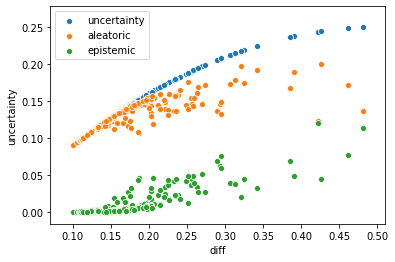

In [20]:
dist = torch.abs(y_test - predictions)
sns.scatterplot(x=dist, y=uncertainties)
sns.scatterplot(x=dist, y=A)
sns.scatterplot(x=dist, y=E)
plt.xlabel("diff")
plt.ylabel("uncertainty")
plt.legend(labels=['uncertainty', 'aleatoric', 'epistemic'])

tensor(412) tensor(1., dtype=torch.float64) tensor(0.5194, dtype=torch.float64) tensor(0.2496, dtype=torch.float64) tensor(0.1363, dtype=torch.float64) tensor(0.1133, dtype=torch.float64)


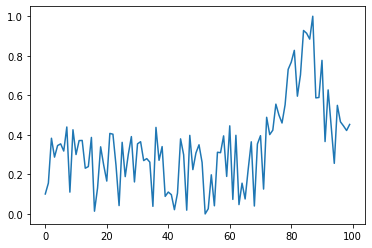

In [21]:
i = dist.argmax()
print(i, y_test[i], predictions[i], uncertainties[i], A[i], E[i])
plt.plot(x_test[i])

### Spread pre and post sigmoid analysis

In [22]:
net.eval()
with torch.no_grad():
    pre_sigmoid = net(x_test.transpose(-2, -3))
    post_sigmoid = torch.sigmoid(pre_sigmoid)

In [23]:
T, B = pre_sigmoid.shape[0:2]
pre_sigmoid_df = pd.DataFrame(columns=["entry","value"])
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j in range(20):
        pre_sigmoid_df.loc[i*B + j] = (j+1, pre_sigmoid[i,j][0])
        post_sigmoid_df.loc[i*B + j] = (j+1, post_sigmoid[i,j][0])

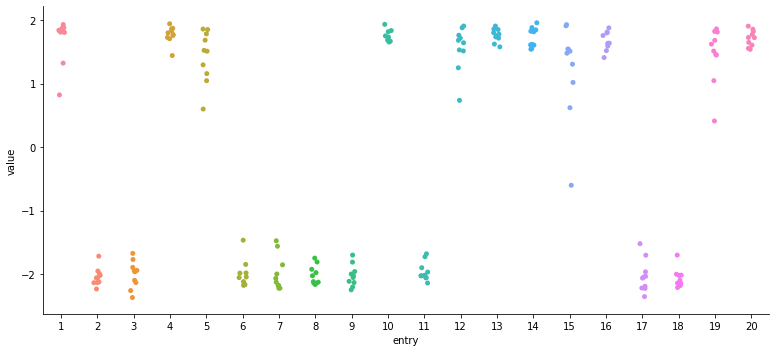

In [24]:
plot = sns.catplot(x="entry", y="value", data=pre_sigmoid_df)
plot.fig.set_figwidth(12)

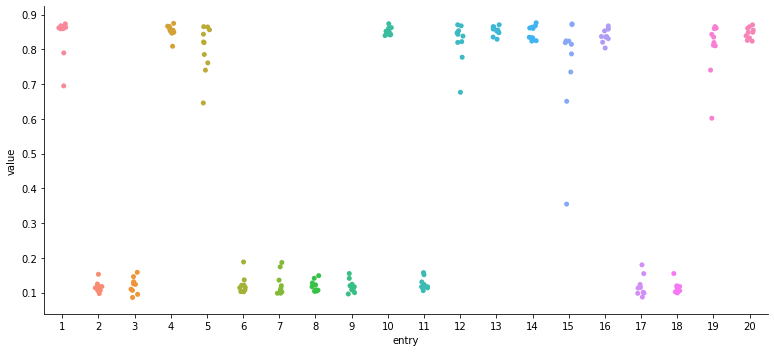

In [25]:
plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)

### Flat line test

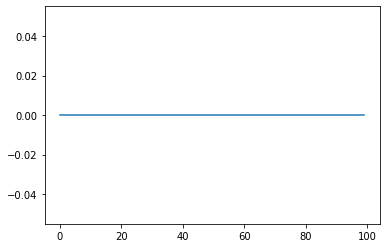

predictions tensor([0.8487, 0.8563], dtype=torch.float64)
uncertainties tensor([0.1284, 0.1231], dtype=torch.float64)


In [26]:
new_x_test = minmax_scale(np.full((2, 100), 3.), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

net.eval()
with torch.no_grad():
    outputs = net(new_x_test)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.flatten(1)
    uncertainties = uncertainty_avg(outputs)
    predictions = prediction_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", predictions)
print("uncertainties", uncertainties)

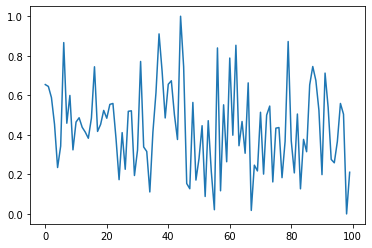

predictions tensor([0.3413, 0.3360], dtype=torch.float64)
uncertainties tensor([0.2248, 0.2231], dtype=torch.float64)


In [27]:
new_x_test = minmax_scale(np.random.randn(2, 100), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

net.eval()
with torch.no_grad():
    outputs = net(new_x_test)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.flatten(1)
    uncertainties = uncertainty_avg(outputs)
    predictions = prediction_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", predictions)
print("uncertainties", uncertainties)

### Note
In binary classification, the maximum uncertainty is 0.25 (need to verify this), and the minimum is 0.